# Find the best place to stay in New York City¶

In [1]:
import pandas as pd
import locale
import requests
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import json
from math import sin, cos, sqrt, atan2, radians
from sklearn.cluster import KMeans
import matplotlib.path as mpltPath
locale.setlocale(locale.LC_ALL, '')

'en_US.UTF-8'

# Install folium library for Maps

In [3]:
!pip install folium

     |████████████████████████████████| 102kB 13.4MB/s ta 0:00:01


In [4]:
import folium
from folium import plugins

In [5]:
!wget -q -O 'Neighborhood Tabulation Areas.geojson' https://cloud-object-storage-sf-cos-standard-pyhton2.s3.us-south.cloud-object-storage.appdomain.cloud/Neighborhood%20Tabulation%20Areas%20Manhattan.geojson 'Neighborhood Tabulation Areas.geojson'
print('Data downloaded!')
newyork_data_filename = 'Neighborhood Tabulation Areas.geojson'

Data downloaded!


In [6]:
with open(newyork_data_filename) as json_data:
    newyork_data = json.load(json_data)
# Create New York Area Tabulation Data Polygons
neighborhoods_polygons = {}
for neighborhood in newyork_data['features']:
    name = neighborhood['properties']['ntaname']
    neighborhoods_polygons[name] = neighborhood['geometry']

In [7]:
# Function to define NYC Tab Area by latitude, longitude
def define_tab_area(latitude, longitude):
    point = [[longitude,latitude]]
    for k,v in neighborhoods_polygons.items():                
        polygon_shapes = v['coordinates']      
        if len(polygon_shapes) == 1:
            path = mpltPath.Path(polygon_shapes[0][0])
            if path.contains_points(point):
                return k
        else:
            for p in polygon_shapes:
                path = mpltPath.Path(p[0])
                if path.contains_points(point):
                    return k        
    return 'Not defined'
        
define_tab_area(40.72290,-73.98199)

'Lower East Side'

In [8]:
#Neighborhood Tabulation Areas.geojson file contains only polygon area cordinates for each Neighborhoods
# So we need to define a Centroid point's 'latitude', 'longitude' for each Manhattan's Neighborhoods
# We re-calculated it, made some manual correction because Nominatim service is not quite accurate and stored in NYC_Neiborhood_Lat_Lon_Man.csv in IBM COS
# for i in range(len(newyork_data['features']) -1, -1, -1):
#     if newyork_data['features'][i]["properties"]["boro_name"] != 'Manhattan':
#         del newyork_data['features'][i]      

# from  geopy.geocoders import Nominatim
# import time
# neighborhoods_data = newyork_data['features']
# data = []
# geolocator = Nominatim(user_agent="courseracapstone")
# for n in neighborhoods_data:
#     city_split =n['properties']['ntaname'].split('-')[0]
#     city =n['properties']['ntaname']
#     print(city_split)
#     if city_split == 'SoHo':
#         city_split = 'Soho'
#     if city_split == 'Battery Park City':
#         city_split = 'Wall Street'   
#     if city_split == 'Clinton':
#         city_split = "Hell's Kitchen"   
#     if city_split == 'Central Harlem North':
#         city_split = "Harlem North"
#     if city_split == 'Central Harlem South':
#         city_split = "Harlem South"                        
        
#     loc = geolocator.geocode(city_split + ", New York")    
#     print("latitude is :-" ,loc.latitude,"\nlongtitude is:-" ,loc.longitude)
#     data.append([city,loc.latitude,loc.longitude])  
#     time.sleep(1)

# neighborhoods_geo = pd.DataFrame(data, columns = ['Neighborhood', 'Latitude', 'Longitude'])
# neighborhoods_geo    

In [9]:

neighborhoods_geo = pd.read_csv('https://cloud-object-storage-sf-cos-standard-pyhton2.s3.us-south.cloud-object-storage.appdomain.cloud/NYC_Neiborhood_Lat_Lon_Man.csv')
neighborhoods_geo.head()

Unnamed: 0                       Neighborhood   Latitude  Longitude
0           0                     Manhattanville  40.815778 -73.951554
1           1                            Clinton  40.764423 -73.992392
2           2                          Chinatown  40.715100 -73.995500
3           3  Battery Park City-Lower Manhattan  40.706784 -74.010147
4           4                     Lincoln Square  40.772319 -73.984401

In [10]:

df= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/listings_NewYork_2019.csv', parse_dates=['last_scraped', 'last_review'])
df.shape

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(50599, 106)

In [11]:
df.head()

id                        listing_url       scrape_id last_scraped  \
0  2595  https://www.airbnb.com/rooms/2595  20191204162729   2019-12-07   
1  3831  https://www.airbnb.com/rooms/3831  20191204162729   2019-12-07   
2  5099  https://www.airbnb.com/rooms/5099  20191204162729   2019-12-06   
3  5121  https://www.airbnb.com/rooms/5121  20191204162729   2019-12-06   
4  5178  https://www.airbnb.com/rooms/5178  20191204162729   2019-12-05   

                                        name  \
0                      Skylit Midtown Castle   
1            Cozy Entire Floor of Brownstone   
2  Large Cozy 1 BR Apartment In Midtown East   
3                            BlissArtsSpace!   
4           Large Furnished Room Near B'way    

                                             summary  \
0  Beautiful, spacious skylit studio in the heart...   
1  Urban retreat: enjoy 500 s.f. floor in 1899 br...   
2  My large 1 bedroom apartment has a true New Yo...   
3                                                NaN   
4  Please don’t expect the luxury here just a bas...   

                                               space  \
0  - Spacious (500+ft²), immaculate and nicely fu...   
1  Greetings!      We own a double-duplex brownst...   
2  I have a large 1 bedroom apartment centrally l...   
3  HELLO EVERYONE AND THANKS FOR VISITING BLISS A...   
4  You will use one large, furnished, private roo...   

                                         description experiences_offered  \
0  Beautiful, spacious skylit studio in the heart...                none   
1  Urban retreat: enjoy 500 s.f. floor in 1899 br...                none   
2  My large 1 bedroom apartment has a true New Yo...                none   
3  HELLO EVERYONE AND THANKS FOR VISITING BLISS A...                none   
4  Please don’t expect the luxury here just a bas...                none   

                               neighborhood_overview  ... instant_bookable  \
0  Centrally located in the heart of Manhattan ju...  ...                f   
1  Just the right mix of urban center and local n...  ...                f   
2  My neighborhood in Midtown East is called Murr...  ...                f   
3                                                NaN  ...                f   
4    Theater district, many restaurants around here.  ...                f   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f                     moderate   
2                        f                     moderate   
3                        f  strict_14_with_grace_period   
4                        f  strict_14_with_grace_period   

  require_guest_profile_picture require_guest_phone_verification  \
0                             t                                t   
1                             f                                f   
2                             t                                t   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               1   
1                               1   
2                               1   
3                               1   
4                               1   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            1   
2                                            1   
3                                            0   
4                                            0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            1   

   calculated_host_listings_count_shared_rooms  reviews_per_month  
0       

In [12]:
# Filter Accomodations 
df_t = df[(df.neighbourhood_group_cleansed == 'Manhattan')
               & (df.number_of_reviews >= 10) 
               & (df.availability_365 >= 10)
               & (df.city=='New York') 
               & (df.state =='NY' )
               & (df.last_scraped > '2019-10-01')
               & (df.last_review > '2019-10-01')
               & (~df.room_type.isin(['Shared room']))
               & (~df.property_type.isin(['Camper/RV', 'Hostel']))
               & (df.minimum_nights < 3 )
              ].copy()

In [13]:
!pip install Babel

In [14]:
import babel
from babel.numbers import format_number, format_decimal, format_percent, parse_decimal

In [15]:


df = df_t[['id',  'name', 'last_review', 'listing_url', 'picture_url', 'neighbourhood_group_cleansed', 'neighbourhood_cleansed', 'review_scores_rating',             
             'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
              'square_feet', 'price', 'security_deposit', 'cleaning_fee',
             'minimum_nights', 'number_of_reviews_ltm', 'reviews_per_month',
             'number_of_reviews', 'availability_365']].copy()
df['price'].fillna('$0', inplace=True)
df['security_deposit'].fillna('$0', inplace=True)
df['cleaning_fee'].fillna('$0', inplace=True)
df.fillna('0', inplace=True)
df= df.astype({'bathrooms':'int','bedrooms':'int', 'square_feet':'int'})
df['price'] = df['price'].apply(lambda x: x.strip("$"))
df['price'] = df['price'].apply(lambda money:  babel.numbers.parse_decimal(money, locale='en'))
df['security_deposit'] = df['security_deposit'].apply(lambda x: x.strip("$"))
df['security_deposit'] = df['security_deposit'].apply(lambda money:  babel.numbers.parse_decimal(money, locale='en'))
df['cleaning_fee'] = df['cleaning_fee'].apply(lambda x: x.strip("$"))
df['cleaning_fee'] = df['cleaning_fee'].apply(lambda money:  babel.numbers.parse_decimal(money, locale='en'))

In [16]:

df_crime= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/NYPD_Crime_Manhattan_2019.csv')
df_crime.shape

(461711, 35)

In [17]:
df_crime[['Latitude','Longitude']] = df_crime[['Latitude','Longitude']].apply(lambda x: x.str.replace(',','.').astype(float))
df_crime.head()

CMPLNT_NUM  ADDR_PCT_CD    BORO_NM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT  \
0   314773184           48      BRONX     31.12.19  06:00:00 PM          NaN   
1   289837961           25  MANHATTAN     30.12.19  08:30:00 PM     31.12.19   
2   535744284           77   BROOKLYN     24.12.19  04:55:00 PM     24.12.19   
3   895678119           52      BRONX     30.12.19  07:32:00 PM          NaN   
4   299841674           18  MANHATTAN     30.12.19  03:30:00 PM     30.12.19   

  CMPLNT_TO_TM CRM_ATPT_CPTD_CD HADEVELOPT  HOUSING_PSA  ...  SUSP_SEX  \
0          NaN        COMPLETED        NaN          NaN  ...         U   
1  10:00:00 AM        COMPLETED        NaN          NaN  ...       NaN   
2  05:00:00 PM        COMPLETED        NaN          NaN  ...         M   
3          NaN        COMPLETED        NaN          NaN  ...         F   
4  04:50:00 PM        COMPLETED        NaN          NaN  ...       NaN   

  TRANSIT_DISTRICT  VIC_AGE_GROUP        VIC_RACE VIC_SEX X_COORD_CD  \
0              NaN          45-64  WHITE HISPANIC       F    1016990   
1              NaN          25-44  WHITE HISPANIC       F     999296   
2              NaN          18-24           WHITE       M    1001068   
3              NaN        UNKNOWN         UNKNOWN       D    1009690   
4              NaN          25-44  WHITE HISPANIC       M     985766   

  Y_COORD_CD   Latitude  Longitude                                   Lat_Lon  
0     244612  40.838026 -73.881681  (40.838026269000075, -73.88168118799997)  
1     230862  40.800334 -73.945657  (40.800334261000046, -73.94565697199994)  
2     183317  40.669832 -73.939376   (40.66983179600004, -73.93937555099996)  
3     257590  40.873671 -73.908014   (40.87367103500002, -73.90801364899994)  
4     216503  40.760935 -73.994529   (40.76093528000007, -73.99452906599998)  

[5 rows x 35 columns]

In [18]:
# Filter crimes
df_manhattan_crime = df_crime[ (df_crime.BORO_NM =='MANHATTAN') & (df_crime.LAW_CAT_CD.isin(['FELONY', 'MISDEMEANOR']))]
df_manhattan_crime.shape

(101086, 35)

In [19]:
df_manhattan_crime['tab_area'] =  df_manhattan_crime.apply(lambda row : define_tab_area(row['Latitude'], row['Longitude']), axis = 1) 

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
df_manhattan_crime = df_manhattan_crime[~(df_manhattan_crime['tab_area'] == 'Not defined')]
df_manhattan_crime.shape

(100961, 36)

In [21]:
#Function to calculate a distance between two points in km
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p))/2
    return 12742 * sin(sqrt(a))

In [22]:
# Function to calculate crimes nearby each accomodation
def calculate_crimes(lat1, lon1):
    num_of_crimes = 0
    for rowc in df_manhattan_crime.itertuples(index=False):
        d = distance(lat1, lon1, rowc.Latitude, rowc.Longitude)
        if d <= radius_km:
            num_of_crimes += 1
    return num_of_crimes

#df['crimes'] = df.apply(lambda row: calculate_crimes(row['latitude'], row['longitude']), axis=1)

In [23]:

radius_km = 0.1
df_airnb= pd.read_csv('https://s3.us-south.cloud-object-storage.appdomain.cloud/cloud-object-storage-sf-cos-standard-pyhton2/airnb_nyc_crime_apply.csv')
df_airnb.shape

(2356, 25)

In [24]:
df_airnb.head()

id                                              name last_review  \
0   5178                  Large Furnished Room Near B'way   2019-11-21   
1   7322  Chelsea Perfect  by Doti, an AIRBNB  Super Host!  2019-11-16   
2   9704               Spacious 1 bedroom in luxe building  2019-11-09   
3  12192                               ENJOY Downtown NYC!  2019-11-13   
4  15711        2 bedroom - Upper East Side-great for kids  2019-11-24   

                          listing_url  \
0   https://www.airbnb.com/rooms/5178   
1   https://www.airbnb.com/rooms/7322   
2   https://www.airbnb.com/rooms/9704   
3  https://www.airbnb.com/rooms/12192   
4  https://www.airbnb.com/rooms/15711   

                                         picture_url  \
0  https://a0.muscache.com/im/pictures/12065/f070...   
1  https://a0.muscache.com/im/pictures/23207/3325...   
2  https://a0.muscache.com/im/pictures/38418/569b...   
3  https://a0.muscache.com/im/pictures/93658190/6...   
4  https://a0.muscache.com/im/pictures/c444be23-6...   

  neighbourhood_group_cleansed neighbourhood_cleansed  review_scores_rating  \
0                    Manhattan         Hell's Kitchen                  84.0   
1                    Manhattan                Chelsea                  96.0   
2                    Manhattan                 Harlem                  98.0   
3                    Manhattan           East Village                  88.0   
4                    Manhattan        Upper East Side                  93.0   

   latitude  longitude  ... square_feet  price  security_deposit  \
0  40.76489  -73.98493  ...           0   79.0               0.0   
1  40.74192  -73.99501  ...           0  120.0               0.0   
2  40.81305  -73.95466  ...         900   52.0             150.0   
3  40.72290  -73.98199  ...           0   68.0             100.0   
4  40.77065  -73.95269  ...           0  250.0             500.0   

   cleaning_fee  minimum_nights  number_of_reviews_ltm  reviews_per_month  \
0          15.0               2                     47               3.52   
1           0.0               1                     50               2.32   
2          50.0               2                     17               1.45   
3          30.0               2                     23               2.10   
4         200.0               2                     11               0.62   

   number_of_reviews  availability_365  crimes  
0                454               242     459  
1                296                26      48  
2                 97               326      19  
3                258                62      93  
4                 75               232      32  

[5 rows x 25 columns]

In [25]:
df_airnb['price_per_person'] =  (df_airnb['price'] + df_airnb['cleaning_fee'])/df_airnb['accommodates']
df_airnb['full_price'] = df_airnb['price'] + df_airnb['cleaning_fee']

In [26]:
df_airnb['tab_area'] =  df_airnb.apply(lambda row : define_tab_area(row['latitude'], row['longitude']), axis = 1) 
df_airnb.head()

id                                              name last_review  \
0   5178                  Large Furnished Room Near B'way   2019-11-21   
1   7322  Chelsea Perfect  by Doti, an AIRBNB  Super Host!  2019-11-16   
2   9704               Spacious 1 bedroom in luxe building  2019-11-09   
3  12192                               ENJOY Downtown NYC!  2019-11-13   
4  15711        2 bedroom - Upper East Side-great for kids  2019-11-24   

                          listing_url  \
0   https://www.airbnb.com/rooms/5178   
1   https://www.airbnb.com/rooms/7322   
2   https://www.airbnb.com/rooms/9704   
3  https://www.airbnb.com/rooms/12192   
4  https://www.airbnb.com/rooms/15711   

                                         picture_url  \
0  https://a0.muscache.com/im/pictures/12065/f070...   
1  https://a0.muscache.com/im/pictures/23207/3325...   
2  https://a0.muscache.com/im/pictures/38418/569b...   
3  https://a0.muscache.com/im/pictures/93658190/6...   
4  https://a0.muscache.com/im/pictures/c444be23-6...   

  neighbourhood_group_cleansed neighbourhood_cleansed  review_scores_rating  \
0                    Manhattan         Hell's Kitchen                  84.0   
1                    Manhattan                Chelsea                  96.0   
2                    Manhattan                 Harlem                  98.0   
3                    Manhattan           East Village                  88.0   
4                    Manhattan        Upper East Side                  93.0   

   latitude  longitude  ... cleaning_fee minimum_nights  \
0  40.76489  -73.98493  ...         15.0              2   
1  40.74192  -73.99501  ...          0.0              1   
2  40.81305  -73.95466  ...         50.0              2   
3  40.72290  -73.98199  ...         30.0              2   
4  40.77065  -73.95269  ...        200.0              2   

   number_of_reviews_ltm  reviews_per_month  number_of_reviews  \
0                     47               3.52                454   
1                     50               2.32                296   
2                     17               1.45                 97   
3                     23               2.10                258   
4                     11               0.62                 75   

   availability_365  crimes  price_per_person  full_price  \
0               242     459              47.0        94.0   
1                26      48              40.0       120.0   
2               326      19              51.0       102.0   
3                62      93              49.0        98.0   
4               232      32              75.0       450.0   

                                     tab_area  
0                                     Clinton  
1  Hudson Yards-Chelsea-Flatiron-Union Square  
2                              Manhattanville  
3                             Lower East Side  
4                 Lenox Hill-Roosevelt Island  

[5 rows x 28 columns]

In [27]:
sorted(df_airnb['tab_area'].unique())

['Battery Park City-Lower Manhattan',
 'Central Harlem North-Polo Grounds',
 'Central Harlem South',
 'Chinatown',
 'Clinton',
 'East Harlem North',
 'East Harlem South',
 'East Village',
 'Gramercy',
 'Hamilton Heights',
 'Hudson Yards-Chelsea-Flatiron-Union Square',
 'Lenox Hill-Roosevelt Island',
 'Lincoln Square',
 'Lower East Side',
 'Manhattanville',
 'Marble Hill-Inwood',
 'Midtown-Midtown South',
 'Morningside Heights',
 'Murray Hill-Kips Bay',
 'SoHo-TriBeCa-Civic Center-Little Italy',
 'Stuyvesant Town-Cooper Village',
 'Turtle Bay-East Midtown',
 'Upper East Side-Carnegie Hill',
 'Upper West Side',
 'Washington Heights North',
 'Washington Heights South',
 'West Village',
 'Yorkville',
 'park-cemetery-etc-Manhattan']

Text(0.5, 0.98, '')

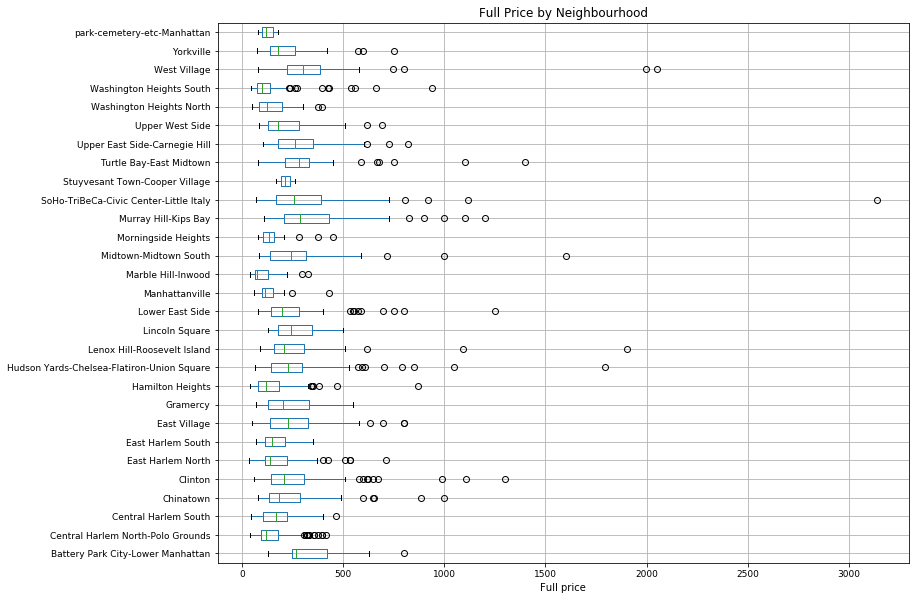

In [28]:
bp = df_airnb[['tab_area','full_price']].boxplot(column='full_price', by='tab_area',vert=False, fontsize=9, figsize=(12,10) )
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

In [29]:
Q1 = df_airnb['full_price'].quantile(0.25)
Q3 = df_airnb['full_price'].quantile(0.75)
IQR = Q3 - Q1

filter = (df_airnb['full_price'] >= Q1 - 1.5 * IQR) & (df_airnb['full_price'] <= Q3 + 1.5 *IQR)
df_airnb_norm = df_airnb.loc[filter]  
df_airnb_norm.shape

(2252, 28)

Text(0.5, 0.98, '')

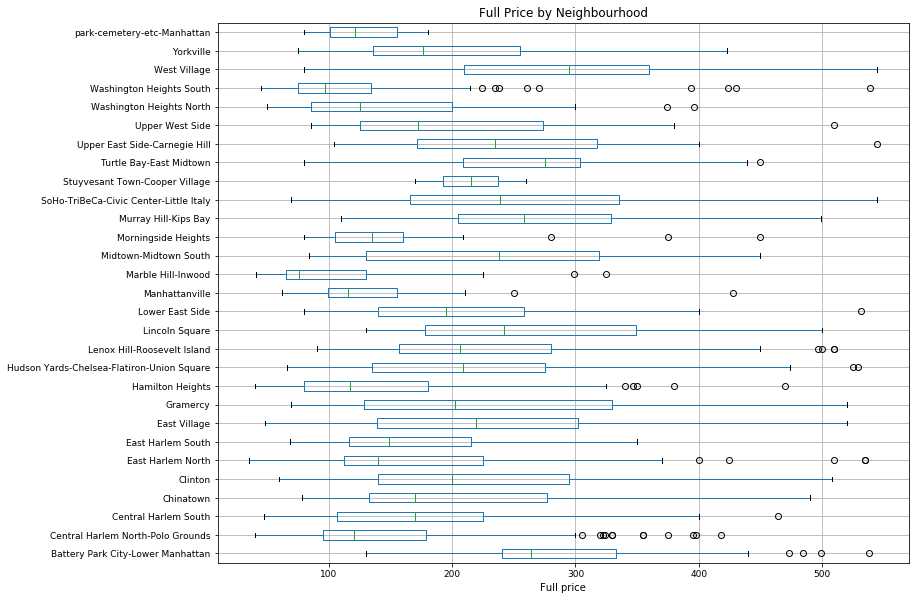

In [30]:
bp = df_airnb_norm[['tab_area','full_price']].boxplot(column='full_price', by='tab_area',vert=False, fontsize=9, figsize=(12,10))
bp.get_figure().gca().set_title("Full Price by Neighbourhood")
bp.get_figure().gca().set_xlabel('Full price')
bp.get_figure().suptitle('')

In [31]:
neighbourhood_crime_price_merged = df_airnb_norm.copy()
neighbourhood_crime_price_merged = neighbourhood_crime_price_merged.groupby("tab_area", as_index=False).agg({'crimes':'mean', 'price_per_person':'mean', 'accommodates':'count'})
neighbourhood_crime_price_merged.columns=['tab_area', 'mean_crimes', 'mean_price_per_person', 'accommodates']

In [32]:
neighbourhood_crime_price_merged[['tab_area', 'mean_price_per_person', 'accommodates', 'mean_crimes']].sort_values('mean_price_per_person')

tab_area  mean_price_per_person  \
15                          Marble Hill-Inwood              45.475238   
25                    Washington Heights South              46.793172   
24                    Washington Heights North              54.738050   
1            Central Harlem North-Polo Grounds              57.038497   
14                              Manhattanville              59.746667   
9                             Hamilton Heights              60.069404   
28                 park-cemetery-etc-Manhattan              61.404762   
5                            East Harlem North              62.275497   
6                            East Harlem South              64.950000   
2                         Central Harlem South              67.000823   
17                         Morningside Heights              71.386054   
23                             Upper West Side              78.127907   
16                       Midtown-Midtown South              81.491705   
0            Battery Park City-Lower Manhattan              82.133130   
3                                    Chinatown              82.362703   
4                                      Clinton              84.308819   
7                                 East Village              84.842758   
13                             Lower East Side              88.452617   
10  Hudson Yards-Chelsea-Flatiron-Union Square              88.591179   
27                                   Yorkville              89.692529   
18                        Murray Hill-Kips Bay              90.410167   
8                                     Gramercy              94.364931   
21                     Turtle Bay-East Midtown              94.817296   
11                 Lenox Hill-Roosevelt Island              96.636218   
22               Upper East Side-Carnegie Hill              96.988889   
19      SoHo-TriBeCa-Civic Center-Little Italy             105.384002   
20              Stuyvesant Town-Cooper Village             107.500000   
12                              Lincoln Square             112.514286   
26                                West Village             112.854167   

    accommodates  mean_crimes  
15            25    54.440000  
25            82    57.682927  
24            53    50.886792  
1            132    73.265152  
14            25    70.520000  
9             97    66.206186  
28             7    13.428571  
5             91   104.824176  
6             77    90.051948  
2             94    87.148936  
17            49    56.204082  
23            86    57.813953  
16            93   139.000000  
0             76    90.394737  
3            123    93.081301  
4            277    84.314079  
7            140    74.385714  
13           101    72.415842  
10           136    77.816176  
27            58    65.000000  
18            62    48.016129  
8             48    84.791667  
21            53    60.509434  
11            52    45.019231  
22            24    62.833333  
19            81    71.962963  
20             2    47.000000  
12            20    87.300000  
26            88    99.863636

In [33]:
neighbourhood_crime_price_merged3 = neighbourhood_crime_price_merged.copy()
neighbourhood_crime_price_merged3 = neighbourhood_crime_price_merged3.merge(neighborhoods_geo[['Latitude', 'Longitude','Neighborhood']], how = 'left', left_on = 'tab_area', right_on = 'Neighborhood').drop(columns= ['Neighborhood'])

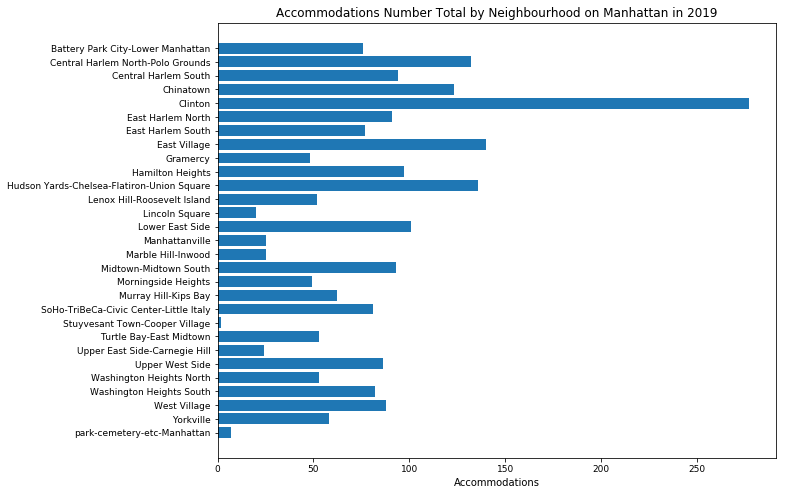

In [34]:
fig, ax = plt.subplots(figsize=(10,8))
x = neighbourhood_crime_price_merged3.index
y = neighbourhood_crime_price_merged3.accommodates
xticks = neighbourhood_crime_price_merged3.tab_area
ax.barh(x, y)
ax.set_yticks(x)
ax.set_yticklabels(xticks)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Accommodations')
ax.set_title('Accommodations Number Total by Neighbourhood on Manhattan in 2019')
plt.tick_params(labelsize=9)
plt.show()

In [35]:
df_manhattan_crime_neighbourhood = df_manhattan_crime.copy()
df_manhattan_crime_neighbourhood = df_manhattan_crime_neighbourhood.groupby("tab_area", as_index=False).agg({'CMPLNT_NUM':'count'})
df_manhattan_crime_neighbourhood.columns=['tab_area', 'crimes_summary']
df_manhattan_crime_neighbourhood.sort_values('crimes_summary')

tab_area  crimes_summary
20              Stuyvesant Town-Cooper Village             145
28                 park-cemetery-etc-Manhattan            1213
11                 Lenox Hill-Roosevelt Island            1604
14                              Manhattanville            1832
27                                   Yorkville            1898
15                          Marble Hill-Inwood            1900
8                                     Gramercy            2021
17                         Morningside Heights            2321
18                        Murray Hill-Kips Bay            2333
7                                 East Village            2340
24                    Washington Heights North            2440
12                              Lincoln Square            2636
21                     Turtle Bay-East Midtown            2643
9                             Hamilton Heights            2738
0            Battery Park City-Lower Manhattan            2883
3                                    Chinatown            3137
22               Upper East Side-Carnegie Hill            3403
6                            East Harlem South            3629
13                             Lower East Side            3650
25                    Washington Heights South            3682
2                         Central Harlem South            4320
4                                      Clinton            4364
23                             Upper West Side            4700
26                                West Village            4748
19      SoHo-TriBeCa-Civic Center-Little Italy            4789
1            Central Harlem North-Polo Grounds            5186
5                            East Harlem North            6221
10  Hudson Yards-Chelsea-Flatiron-Union Square            7788
16                       Midtown-Midtown South           10397

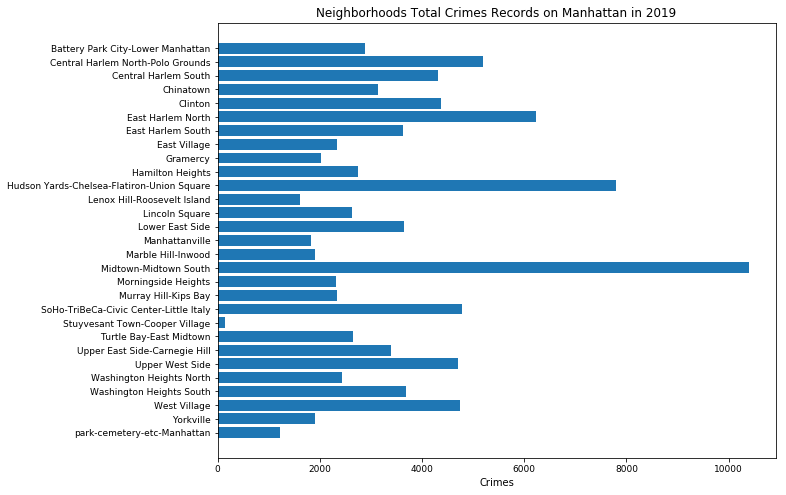

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
x = df_manhattan_crime_neighbourhood.index
y = df_manhattan_crime_neighbourhood.crimes_summary
xticks = df_manhattan_crime_neighbourhood.tab_area
ax.barh(x, y)
ax.set_yticks(x)
ax.set_yticklabels(xticks)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Crimes')
ax.set_title('Neighborhoods Total Crimes Records on Manhattan in 2019')
plt.tick_params(labelsize=9)
plt.show()

In [37]:
df_manhattan_crime_neighbourhood2 = df_manhattan_crime_neighbourhood.copy()
df_manhattan_crime_neighbourhood2 = df_manhattan_crime_neighbourhood2.merge(neighborhoods_geo[['Latitude', 'Longitude','Neighborhood']], how = 'left', left_on = 'tab_area', right_on = 'Neighborhood').drop(columns= ['Neighborhood'])
df_manhattan_crime_neighbourhood2.head()

tab_area  crimes_summary   Latitude  Longitude
0  Battery Park City-Lower Manhattan            2883  40.706784 -74.010147
1  Central Harlem North-Polo Grounds            5186  40.819400 -73.941200
2               Central Harlem South            4320  40.802900 -73.952300
3                          Chinatown            3137  40.715100 -73.995500
4                            Clinton            4364  40.764423 -73.992392

In [38]:
# Neighborhoods prices on Manhattan in 2019
nyc_lat = 40.758896
nyc_lon = -73.985130
nyc_official_neighbourhoods_price_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
nyc_official_neighbourhoods_price_map.choropleth(
    geo_data=newyork_data,
    data=neighbourhood_crime_price_merged3,
    columns=['tab_area', 'mean_price_per_person'],
    key_on='properties.ntaname',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Price/Neighbourhoods in New York 2019')

# Add Official Neighbourhoods names
for lat, lng, poi, mean_price_per_person, accommodates, mean_crimes  in zip(neighbourhood_crime_price_merged3['Latitude'],
                                                                         neighbourhood_crime_price_merged3['Longitude'], 
                                                                         neighbourhood_crime_price_merged3['tab_area'],
                                                                         round(neighbourhood_crime_price_merged3['mean_price_per_person'],2), 
                                                                         neighbourhood_crime_price_merged3['accommodates'],
                                                                         round(neighbourhood_crime_price_merged3['mean_crimes'],2)):
    label = folium.Popup(str(poi) +  '|| Mean Price per person: $' + str(mean_price_per_person)  +', Accommodates Number: ' + str(accommodates)  + ', Mean Crimes: ' + str(mean_crimes), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_official_neighbourhoods_price_map)  
    
nyc_official_neighbourhoods_price_map

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [39]:
df_airnb_norm_data = df_airnb_norm.iloc[:].copy()
accomodations = folium.map.FeatureGroup()
for lat, lng, poi, rating, full_price, price_per_person, accommodates, crimes, listing_url, picture_url, bathrooms, bedrooms,neighbourhood_cleansed,square_feet in zip(df_airnb_norm_data['latitude'],
                                                                         df_airnb_norm_data['longitude'], 
                                                                         df_airnb_norm_data['name'],
                                                                         df_airnb_norm_data['review_scores_rating'],
                                                                         round(df_airnb_norm_data['full_price'],2), 
                                                                         round(df_airnb_norm_data['price_per_person'],2), 
                                                                         df_airnb_norm_data['accommodates'],
                                                                         round(df_airnb_norm_data['crimes'],2),
                                                                         df_airnb_norm_data['listing_url'],
                                                                         df_airnb_norm_data['picture_url'],
                                                                         df_airnb_norm_data['bathrooms'],
                                                                         df_airnb_norm_data['bedrooms'],
                                                                         df_airnb_norm_data['neighbourhood_cleansed'],
                                                                         df_airnb_norm_data['square_feet']
                                                                        ):
    html = f"""
     <br /> 
     <b>Accommodation: </b>{poi} <br />  
     <b>Host: </b><a href='{listing_url}'>{listing_url}</a>  <br />  
     <b>Neighbourhood: </b> {neighbourhood_cleansed}<br />  
     <b>Rating: </b> {rating}<br />  
     <b>Full price (USD): </b>{full_price}  <br />   
     <b>Price per Person (USD): </b>{price_per_person} <br /> 
     <b>Accommodates: </b>{accommodates}<br /> 
     <b>Bathrooms: </b>{bathrooms}<br /> 
     <b>Bedrooms: </b>{bedrooms}<br /> 
     <b>Square feet: </b>{square_feet}<br /> 
     <b>Crimes in 100 meters: </b>{crimes} <br />      
     <img ALIGN="Right" src="{picture_url}" alt="Host picture" width="300"  height="100">
    """
    #label = folium.Popup(str(poi) +  '|| Full price: $' + str(full_price) + ', Price per person: $' + str(price_per_person)  +', Accommodates: ' + str(accommodates)  + ', Crimes: ' + str(crimes), parse_html=True)
    iframe = folium.IFrame(html=html, width=500, height=350) 
    popup = folium.Popup(iframe, max_width=500)
    accomodations.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=1,
            popup=popup,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )     
nyc_official_neighbourhoods_price_map.add_child(accomodations)

In [40]:
nyc_crime_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=11)
limit = 1000
df_incidents = df_manhattan_crime.sample(limit) 

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(nyc_crime_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, area in zip(df_incidents.Latitude, df_incidents.Longitude, df_incidents.LAW_CAT_CD, df_incidents.tab_area):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)


nyc_crime_map

In [41]:
# Neighborhoods Сrimes Summary on Manhattan in 2019
nyc_lat = 40.758896
nyc_lon = -73.985130
nyc_official_neighbourhoods_crime_map = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
nyc_official_neighbourhoods_crime_map.choropleth(
    geo_data=newyork_data,
    data=df_manhattan_crime_neighbourhood2,
    columns=['tab_area', 'crimes_summary'],
    key_on='properties.ntaname',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Crime/Neighbourhoods in New York 2019')

# Add Official Neighbourhoods names
for lat, lng, poi, crimes_summary  in zip(df_manhattan_crime_neighbourhood2['Latitude'],
                                                                         df_manhattan_crime_neighbourhood2['Longitude'], 
                                                                         df_manhattan_crime_neighbourhood2['tab_area'],
                                                                         df_manhattan_crime_neighbourhood2['crimes_summary']
                                                                        ):
    label = folium.Popup(str(poi) +  '|| Crimes Summary: ' + str(crimes_summary), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color='#8B0000',
        fill_opacity=0.7,
        parse_html=False).add_to(nyc_official_neighbourhoods_crime_map)  
    

nyc_official_neighbourhoods_crime_map

In [42]:
limit=100
df_airnb_top = df_airnb_norm.sort_values(by=['review_scores_rating',  'full_price','price_per_person',  'crimes'], ascending=[False, True, True, True])[['name', 'tab_area', 'neighbourhood_cleansed','latitude', 'longitude' ,'review_scores_rating',  'property_type', 'room_type', 'accommodates', 'full_price', 'price_per_person', 'crimes', 'listing_url','picture_url','bathrooms', 'bedrooms','square_feet']].head(limit)

In [43]:
df_airnb_top.head()

name  \
2029  Private Bedroom in Cozy Hamilton Heights Apart...   
1801                      Mr. B - Room Apartment in NYC   
1354  Cozy sanctuary/Big master bedroom/NYC/The Heights   
1529                                  Little Safe Haven   
654   One cozy private BR close to the mecca of shop...   

                      tab_area neighbourhood_cleansed  latitude  longitude  \
2029          Hamilton Heights                 Harlem  40.82749  -73.94461   
1801  Washington Heights South     Washington Heights  40.84377  -73.94094   
1354  Washington Heights North     Washington Heights  40.84911  -73.93097   
1529          Hamilton Heights                 Harlem  40.82494  -73.94280   
654    Turtle Bay-East Midtown                Midtown  40.76026  -73.96590   

      review_scores_rating property_type     room_type  accommodates  \
2029                 100.0     Apartment  Private room             2   
1801                 100.0     Apartment  Private room             1   
1354                 100.0     Apartment  Private room             2   
1529                 100.0     Apartment  Private room             1   
654                  100.0     Apartment  Private room             1   

      full_price  price_per_person  crimes  \
2029        54.0              27.0      34   
1801        67.0              67.0      32   
1354        74.0              37.0      78   
1529        80.0              80.0      43   
654         80.0              80.0      64   

                                listing_url  \
2029  https://www.airbnb.com/rooms/34770173   
1801  https://www.airbnb.com/rooms/32589616   
1354  https://www.airbnb.com/rooms/26303788   
1529  https://www.airbnb.com/rooms/29205817   
654   https://www.airbnb.com/rooms/13246804   

                                            picture_url  bathrooms  bedrooms  \
2029  https://a0.muscache.com/im/pictures/aff6d2a3-b...          1         1   
1801  https://a0.muscache.com/im/pictures/88aec7e7-e...          1         1   
1354  https://a0.muscache.com/im/pictures/fcc9077f-f...          1         1   
1529  https://a0.muscache.com/im/pictures/97143bde-7...          1         1   
654   https://a0.muscache.com/im/pictures/b4722160-b...          1         2   

      square_feet  
2029            0  
1801            0  
1354            0  
1529            0  
654             0

In [44]:
CLIENT_ID = 'JSCTW5AW4Q0KYX2HBKMFL1DBCYUSVPI11ZX5REPVRHHXYZ2F'
CLIENT_SECRET = 'YYPDCSIFGOGGGMHFXYRLW1GTSSTGPYL4OAE5UAW5BIIKV2QU' 
VERSION = '20210202' # Foursquare API version
LIMIT = 50
RADIUS = 1000

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: JSCTW5AW4Q0KYX2HBKMFL1DBCYUSVPI11ZX5REPVRHHXYZ2F
CLIENT_SECRET:YYPDCSIFGOGGGMHFXYRLW1GTSSTGPYL4OAE5UAW5BIIKV2QU


In [45]:
def getAccomodatesNearbyVenues(names, latitudes, longitudes, radius, limit):
    venues_list=[]
    nearby_venues = pd.DataFrame()
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        try:
            response = requests.get(url)
            if response.status_code == 200: 
                results = response.json()["response"]['groups'][0]['items']
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['venue']['name'], 
                    v['venue']['location']['lat'], 
                    v['venue']['location']['lng'],  
                    v['venue']['categories'][0]['name']) for v in results])

                nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
                nearby_venues.columns = ['name', 
                                         'latitude', 
                                         'longitude', 
                                         'Venue', 
                                         'Venue Latitude', 
                                         'Venue Longitude', 
                                         'Venue Category']
            else:
                print ("Exception during call URL={} , Code={}, Text={}".format(url, response.status_code, response.text))
        except Exception as e:
            print ("Exception: {}".format(e))
            raise e
    
    return(nearby_venues)

In [46]:
df_airnb_top_venues = getAccomodatesNearbyVenues(names=df_airnb_top['name'],
                                   latitudes=df_airnb_top['latitude'],
                                   longitudes=df_airnb_top['longitude'],
                                   radius = RADIUS,
                                   limit = LIMIT
                                  )

Private Bedroom in Cozy Hamilton Heights Apartment
Mr. B - Room Apartment in NYC
Cozy sanctuary/Big master bedroom/NYC/The Heights
Little Safe Haven
One cozy private BR close to the mecca of shopping
Spacious and Modern Hideout | Close to Everything
Master Suite near NYP/CUMC and 2 blks from Subway
Gorgeous Manhattan Hideout | Close to Everything
Old School New York
157-C
Large UWS Private Bedroom with Outdoor Space
Park-lovers Paradise in Central Manhattan
A neat bedroom in a cozy 3-bedroom apartment
Massive sun filled room on Central Park West.
airy, earthy room in artistic apt
U W S Sunny Queen size bedroom near Columbia UNI*
Luxury Street View Room 2 blocks from Times Square
Huge modern room in a cozy sunny home
Beautiful, sunlit private room in Spanish Harlem
Spacious & bright apartment in the heart of Harlem
Contemporary bedroom in a cozy sunny home
Bright Bohemian Gem in the Lower East Side
Nice private room in quiet E Village apt
Spanish Harlem magical place. Mezzanine bed
Spac

In [47]:
df_airnb_top_venues.head()

name  latitude  longitude  \
0  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
1  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
2  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
3  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
4  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   

                   Venue  Venue Latitude  Venue Longitude Venue Category  
0     Branson Got Juice!       40.825525       -73.943681      Juice Bar  
1  Camila’s Tasting Room       40.827680       -73.946073            Bar  
2          Harlem Public       40.828803       -73.948685            Bar  
3          The Honeywell       40.828549       -73.948739      Speakeasy  
4             Monkey Cup       40.825694       -73.947234    Coffee Shop

In [48]:
df_airnb_top_venues.shape

(5000, 7)

In [49]:
fine_art_cat = ['Art','Arts','Museum', 'Library','Exhibit','Gallery']
eat_place_cat = ['Restaurant','Steakhouse']
shopping_cat = ['Shopping Mall','Market','Boutique']
outdoor_cat = ['Sculpture Garden','Scenic Lookout','Roof Deck','Outdoor Sculpture','Monument / Landmark',
               'Memorial Site','Lighthouse','Historic Site','Harbor / Marina','Fountain','Event Space','Bridge',
               'Waterfront','Church','Building','Garden','Historic Site','Lake','Park',
               'Pier','Rest Area','River','Synagogue','Field']
entertainment_cat = ['Nightclub','Circus','Club', 'Stadium', 'Karaoke Bar', 'Pub','Theater','Opera', 'Concert', 'Zoo']

#Join all categories' values in one
tourists_categories = fine_art_cat + eat_place_cat + shopping_cat + outdoor_cat +entertainment_cat

In [50]:
# We need Venues only from our Custom Categories
def check(category):
    if any(word in category for word in tourists_categories):
        return True
    return False

In [51]:
# Define Venue's Category
def change_categoty(name):
    if any(word in name for word in entertainment_cat):
        return 'Entertainment'
    if any(word in name for word in fine_art_cat):
        return 'Fine Art'
    if any(word in name for word in eat_place_cat):
        return 'Food Place'
    if any(word in name for word in shopping_cat):        
        return 'Shopping'
    if any(word in name for word in outdoor_cat):            
        return 'Sightseeing'
    if any(word in name for word in tansportation_cat):            
        return 'Transportation'    

In [52]:
# Define Top Venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)      
    return row_categories_sorted.index.values[0:num_top_venues] 

def return_most_common_venues_stats(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False).astype(float)      
    return row_categories_sorted.values[0:num_top_venues]

In [53]:
df_airnb_top_venues_f = df_airnb_top_venues[df_airnb_top_venues['Venue Category'].apply(lambda x: check(x))].copy()
df_airnb_top_venues_f.head()

name  latitude  longitude  \
5   Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
7   Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
9   Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
13  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
14  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   

                           Venue  Venue Latitude  Venue Longitude  \
5                 Convent Garden       40.828560       -73.942531   
7            Wat’s On Your Plate       40.825632       -73.948494   
9                 Bono Trattoria       40.830180       -73.947420   
13                Benyam Cuisine       40.825075       -73.940358   
14  Riverside Drive Running Path       40.827738       -73.942124   

          Venue Category  
5                 Garden  
7   Caribbean Restaurant  
9     Italian Restaurant  
13  Ethiopian Restaurant  
14        Scenic Lookout

In [54]:
df_airnb_top_venues_f.rename(columns = {'Venue Category':'Venue Type'}, inplace = True)

In [55]:
df_airnb_top_venues_f['Venue Category'] = df_airnb_top_venues_f['Venue Type'].apply(lambda x: change_categoty(x))
df_airnb_top_venues_f.head()

name  latitude  longitude  \
5   Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
7   Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
9   Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
13  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   
14  Private Bedroom in Cozy Hamilton Heights Apart...  40.82749  -73.94461   

                           Venue  Venue Latitude  Venue Longitude  \
5                 Convent Garden       40.828560       -73.942531   
7            Wat’s On Your Plate       40.825632       -73.948494   
9                 Bono Trattoria       40.830180       -73.947420   
13                Benyam Cuisine       40.825075       -73.940358   
14  Riverside Drive Running Path       40.827738       -73.942124   

              Venue Type Venue Category  
5                 Garden    Sightseeing  
7   Caribbean Restaurant     Food Place  
9     Italian Restaurant     Food Place  
13  Ethiopian Restaurant     Food Place  
14        Scenic Lookout    Sightseeing

In [56]:
# one hot encoding
airnb_onehot = pd.get_dummies(df_airnb_top_venues_f[['Venue Category']], prefix="", prefix_sep="")

# add name column back to dataframe
airnb_onehot['name'] = df_airnb_top_venues_f['name'] 

# move name column to the first column
fixed_columns = [airnb_onehot.columns[-1]] + list(airnb_onehot.columns[:-1])
airnb_onehot = airnb_onehot[fixed_columns]

In [57]:
airnb_grouped = (np.round(airnb_onehot.groupby('name').mean(),2)).reset_index()
airnb_grouped.head()

name  Entertainment  Fine Art  \
0  **Stylish, Quiet, Centrally Located (9th & 52nd)           0.38      0.04   
1                                             157-C           0.05      0.15   
2      A neat bedroom in a cozy 3-bedroom apartment           0.03      0.03   
3      Art filled peaceful paradise EV Union Square           0.08      0.08   
4           Artsy Parisian Apt in Greenwich Village           0.19      0.00   

   Food Place  Shopping  Sightseeing  
0        0.58      0.00         0.00  
1        0.55      0.00         0.25  
2        0.48      0.03         0.41  
3        0.69      0.08         0.08  
4        0.71      0.00         0.10

In [58]:
# Find Top-3 Venues Category
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue Share'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue Share'.format(ind+1))        
        

# create a new dataframe
airnb_venues_sorted = pd.DataFrame(columns=columns)
airnb_venues_sorted['name'] = airnb_grouped['name']

for ind in np.arange(airnb_grouped.shape[0]):
    strings_stats = np.around(return_most_common_venues_stats(airnb_grouped.iloc[ind, :], num_top_venues),2) 
    strings_category = return_most_common_venues(airnb_grouped.iloc[ind, :], num_top_venues)
    airnb_venues_sorted.iloc[ind, 1:] = np.concatenate([strings_category,strings_stats ])

airnb_venues_sorted.head()

name 1st Most Common Venue  \
0  **Stylish, Quiet, Centrally Located (9th & 52nd)            Food Place   
1                                             157-C            Food Place   
2      A neat bedroom in a cozy 3-bedroom apartment            Food Place   
3      Art filled peaceful paradise EV Union Square            Food Place   
4           Artsy Parisian Apt in Greenwich Village            Food Place   

  2nd Most Common Venue 3rd Most Common Venue 1st Most Common Venue Share  \
0         Entertainment              Fine Art                        0.58   
1           Sightseeing              Fine Art                        0.55   
2           Sightseeing              Shopping                        0.48   
3           Sightseeing              Shopping                        0.69   
4         Entertainment           Sightseeing                        0.71   

  2nd Most Common Venue Share 3rd Most Common Venue Share  
0                        0.38                        0.04  
1                        0.25                        0.15  
2                        0.41                        0.03  
3                        0.08                        0.08  
4                        0.19                         0.1

In [59]:
# set number of clusters
kclusters = 3

airnb_grouped_clustering = airnb_grouped.drop('name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(airnb_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 2, 2, 2, 0, 0, 0, 2], dtype=int32)

In [60]:
# add clustering labels
airnb_venues_clustered = airnb_venues_sorted.copy()
airnb_venues_clustered.head()

name 1st Most Common Venue  \
0  **Stylish, Quiet, Centrally Located (9th & 52nd)            Food Place   
1                                             157-C            Food Place   
2      A neat bedroom in a cozy 3-bedroom apartment            Food Place   
3      Art filled peaceful paradise EV Union Square            Food Place   
4           Artsy Parisian Apt in Greenwich Village            Food Place   

  2nd Most Common Venue 3rd Most Common Venue 1st Most Common Venue Share  \
0         Entertainment              Fine Art                        0.58   
1           Sightseeing              Fine Art                        0.55   
2           Sightseeing              Shopping                        0.48   
3           Sightseeing              Shopping                        0.69   
4         Entertainment           Sightseeing                        0.71   

  2nd Most Common Venue Share 3rd Most Common Venue Share  
0                        0.38                        0.04  
1                        0.25                        0.15  
2                        0.41                        0.03  
3                        0.08                        0.08  
4                        0.19                         0.1

In [61]:
airnb_venues_clustered.insert(0, 'Cluster Labels', kmeans.labels_)
airnb_venues_clustered.head()

Cluster Labels                                              name  \
0               1  **Stylish, Quiet, Centrally Located (9th & 52nd)   
1               0                                             157-C   
2               0      A neat bedroom in a cozy 3-bedroom apartment   
3               2      Art filled peaceful paradise EV Union Square   
4               2           Artsy Parisian Apt in Greenwich Village   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0            Food Place         Entertainment              Fine Art   
1            Food Place           Sightseeing              Fine Art   
2            Food Place           Sightseeing              Shopping   
3            Food Place           Sightseeing              Shopping   
4            Food Place         Entertainment           Sightseeing   

  1st Most Common Venue Share 2nd Most Common Venue Share  \
0                        0.58                        0.38   
1                        0.55                        0.25   
2                        0.48                        0.41   
3                        0.69                        0.08   
4                        0.71                        0.19   

  3rd Most Common Venue Share  
0                        0.04  
1                        0.15  
2                        0.03  
3                        0.08  
4                         0.1

In [62]:
airnb_merged = df_airnb_top.copy()
#  add latitude/longitude 
airnb_merged  = airnb_merged.join(airnb_venues_clustered.set_index('name'), on='name')
airnb_merged = airnb_merged.dropna()
airnb_merged.head()

name  \
2029  Private Bedroom in Cozy Hamilton Heights Apart...   
1801                      Mr. B - Room Apartment in NYC   
1354  Cozy sanctuary/Big master bedroom/NYC/The Heights   
1529                                  Little Safe Haven   
654   One cozy private BR close to the mecca of shop...   

                      tab_area neighbourhood_cleansed  latitude  longitude  \
2029          Hamilton Heights                 Harlem  40.82749  -73.94461   
1801  Washington Heights South     Washington Heights  40.84377  -73.94094   
1354  Washington Heights North     Washington Heights  40.84911  -73.93097   
1529          Hamilton Heights                 Harlem  40.82494  -73.94280   
654    Turtle Bay-East Midtown                Midtown  40.76026  -73.96590   

      review_scores_rating property_type     room_type  accommodates  \
2029                 100.0     Apartment  Private room             2   
1801                 100.0     Apartment  Private room             1   
1354                 100.0     Apartment  Private room             2   
1529                 100.0     Apartment  Private room             1   
654                  100.0     Apartment  Private room             1   

      full_price  ...  bathrooms  bedrooms square_feet Cluster Labels  \
2029        54.0  ...          1         1           0              0   
1801        67.0  ...          1         1           0              0   
1354        74.0  ...          1         1           0              0   
1529        80.0  ...          1         1           0              0   
654         80.0  ...          1         2           0              2   

      1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
2029             Food Place            Sightseeing               Fine Art   
1801             Food Place            Sightseeing               Shopping   
1354             Food Place            Sightseeing               Shopping   
1529             Food Place            Sightseeing               Fine Art   
654              Food Place          Entertainment            Sightseeing   

      1st Most Common Venue Share 2nd Most Common Venue Share  \
2029                         0.65                        0.29   
1801                         0.73                        0.23   
1354                         0.75                        0.21   
1529                         0.74                        0.16   
654                          0.68                        0.14   

     3rd Most Common Venue Share  
2029                        0.06  
1801                        0.05  
1354                        0.04  
1529                        0.11  
654                         0.09  

[5 rows x 24 columns]

In [63]:
df_airnb_norm.groupby(['tab_area','neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'tab_area': 'NYC Tab Area', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('NYC Tab Area')

NYC Tab Area Airbnb Neighbourhood  Count
0            Battery Park City-Lower Manhattan    Battery Park City      1
1            Battery Park City-Lower Manhattan   Financial District     75
2            Central Harlem North-Polo Grounds          East Harlem     15
3            Central Harlem North-Polo Grounds               Harlem    117
4                         Central Harlem South               Harlem     94
5                                    Chinatown            Chinatown     48
6                                    Chinatown         Civic Center      1
7                                    Chinatown      Lower East Side     60
8                                    Chinatown          Two Bridges     14
9                                      Clinton       Hell's Kitchen    277
10                           East Harlem North          East Harlem     91
11                           East Harlem South          East Harlem     77
12                                East Village         East Village    140
16                                    Gramercy              Midtown      2
15                                    Gramercy             Kips Bay      5
14                                    Gramercy             Gramercy     39
13                                    Gramercy    Flatiron District      2
17                            Hamilton Heights               Harlem     97
18  Hudson Yards-Chelsea-Flatiron-Union Square              Chelsea     76
19  Hudson Yards-Chelsea-Flatiron-Union Square    Flatiron District      1
20  Hudson Yards-Chelsea-Flatiron-Union Square       Hell's Kitchen     58
21  Hudson Yards-Chelsea-Flatiron-Union Square              Midtown      1
22                 Lenox Hill-Roosevelt Island     Roosevelt Island      7
23                 Lenox Hill-Roosevelt Island      Upper East Side     45
24                              Lincoln Square      Upper West Side     20
25                             Lower East Side            Chinatown      4
26                             Lower East Side         East Village     57
27                             Lower East Side      Lower East Side     40
28                              Manhattanville               Harlem     25
30                          Marble Hill-Inwood          Marble Hill      1
..                                         ...                  ...    ...
31                       Midtown-Midtown South              Chelsea     17
32                       Midtown-Midtown South              Midtown     48
33                       Midtown-Midtown South          Murray Hill      1
34                       Midtown-Midtown South     Theater District     27
35                         Morningside Heights               Harlem      3
36                         Morningside Heights  Morningside Heights     16
37                         Morningside Heights      Upper West Side     30
38                        Murray Hill-Kips Bay             Kips Bay     24
39                        Murray Hill-Kips Bay              Midtown      5
40                        Murray Hill-Kips Bay          Murray Hill     33
45      SoHo-TriBeCa-Civic Center-Little Italy                 SoHo     36
46      SoHo-TriBeCa-Civic Center-Little Italy              Tribeca      5
44      SoHo-TriBeCa-Civic Center-Little Italy               Nolita     19
42      SoHo-TriBeCa-Civic Center-Little Italy         Civic Center      1
41      SoHo-TriBeCa-Civic Center-Little Italy            Chinatown      8
43      SoHo-TriBeCa-Civic Center-Little Italy         Little Italy     12
47              Stuyvesant Town-Cooper Village      Stuyvesant Town      2
48                     Turtle Bay-East Midtown              Midtown     50
49                     Turtle Bay-East Midtown          Murray Hill      3
50               Upper East Side-Carnegie Hill      Upper East Side     24
51                             Upper West Side      Upper West Side     86
52                    Washington Heights North             

In [64]:
df_airnb_norm.groupby(['tab_area']).size().reset_index().rename(columns={0:'Count', 'tab_area': 'NYC Tab Area'}).sort_values('Count', ascending = False)

NYC Tab Area  Count
4                                      Clinton    277
7                                 East Village    140
10  Hudson Yards-Chelsea-Flatiron-Union Square    136
1            Central Harlem North-Polo Grounds    132
3                                    Chinatown    123
13                             Lower East Side    101
9                             Hamilton Heights     97
2                         Central Harlem South     94
16                       Midtown-Midtown South     93
5                            East Harlem North     91
26                                West Village     88
23                             Upper West Side     86
25                    Washington Heights South     82
19      SoHo-TriBeCa-Civic Center-Little Italy     81
6                            East Harlem South     77
0            Battery Park City-Lower Manhattan     76
18                        Murray Hill-Kips Bay     62
27                                   Yorkville     58
21                     Turtle Bay-East Midtown     53
24                    Washington Heights North     53
11                 Lenox Hill-Roosevelt Island     52
17                         Morningside Heights     49
8                                     Gramercy     48
14                              Manhattanville     25
15                          Marble Hill-Inwood     25
22               Upper East Side-Carnegie Hill     24
12                              Lincoln Square     20
28                 park-cemetery-etc-Manhattan      7
20              Stuyvesant Town-Cooper Village      2

In [65]:
df_airnb_norm.groupby(['neighbourhood_cleansed']).size().reset_index().rename(columns={0:'Count', 'neighbourhood_cleansed': 'Airbnb Neighbourhood'}).sort_values('Count', ascending = False)

Airbnb Neighbourhood  Count
10               Harlem    336
11       Hell's Kitchen    335
5          East Village    197
4           East Harlem    183
29      Upper West Side    136
30   Washington Heights    128
28      Upper East Side    127
17              Midtown    106
15      Lower East Side    100
1               Chelsea     93
6    Financial District     75
2             Chinatown     60
31         West Village     49
8              Gramercy     39
12               Inwood     38
19          Murray Hill     37
23                 SoHo     36
9     Greenwich Village     34
13             Kips Bay     29
25     Theater District     27
21               Nolita     19
18  Morningside Heights     16
27          Two Bridges     14
14         Little Italy     12
22     Roosevelt Island      7
20                 NoHo      5
26              Tribeca      5
7     Flatiron District      3
3          Civic Center      2
24      Stuyvesant Town      2
0     Battery Park City      1
16          Marble Hill      1

In [66]:
nyc_lat = 40.758896
nyc_lon = -73.985130
map_clusters = folium.Map(location=[nyc_lat,nyc_lon], zoom_start=12)
accomodations_cl = folium.map.FeatureGroup()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, poi, rating, full_price, price_per_person, accommodates, crimes, listing_url, picture_url, bathrooms, bedrooms,neighbourhood_cleansed,square_feet, cluster in zip(airnb_merged['latitude'],
                                                                         airnb_merged['longitude'], 
                                                                         airnb_merged['name'],
                                                                         airnb_merged['review_scores_rating'],
                                                                         round(airnb_merged['full_price'],2), 
                                                                         round(airnb_merged['price_per_person'],2), 
                                                                         airnb_merged['accommodates'],
                                                                         round(airnb_merged['crimes'],2),
                                                                         airnb_merged['listing_url'],
                                                                         airnb_merged['picture_url'],
                                                                         airnb_merged['bathrooms'],
                                                                         airnb_merged['bedrooms'],
                                                                         airnb_merged['neighbourhood_cleansed'],
                                                                         airnb_merged['square_feet'],
                                                                         airnb_merged['Cluster Labels'].astype(int)):
    html_cl = f"""
     <br /> 
     <b>Cluster: </b>{cluster} <br />  
     <b>Accommodation: </b>{poi} <br />  
     <b>Host: </b><a href='{listing_url}'>{listing_url}</a>  <br />  
     <b>Neighbourhood: </b> {neighbourhood_cleansed}<br />  
     <b>Rating: </b> {rating}<br />  
     <b>Full price (USD): </b>{full_price}  <br />   
     <b>Price per Person (USD): </b>{price_per_person} <br /> 
     <b>Accommodates: </b>{accommodates}<br /> 
     <b>Bathrooms: </b>{bathrooms}<br /> 
     <b>Bedrooms: </b>{bedrooms}<br /> 
     <b>Square feet: </b>{square_feet}<br /> 
     <b>Crimes in 100 meters: </b>{crimes} <br />      
     <img ALIGN="Right" src="{picture_url}" alt="Host picture" width="300"  height="100">
    """
    iframe_cl = folium.IFrame(html=html_cl, width=500, height=350) 
    popup = folium.Popup(iframe_cl, max_width=500)
    accomodations_cl.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5,
            popup=popup,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7
        )
    )     
map_clusters.add_child(accomodations_cl)

In [67]:
cluster0 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 0, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster0.describe()

review_scores_rating  accommodates  full_price  price_per_person  \
count             46.000000     46.000000   46.000000         46.000000   
mean              99.956522      2.630435  195.891304         83.168478   
std                0.206185      1.717345  122.821321         50.946927   
min               99.000000      1.000000   54.000000         27.000000   
25%              100.000000      2.000000   90.000000         54.250000   
50%              100.000000      2.000000  155.000000         65.125000   
75%              100.000000      4.000000  261.000000         93.750000   
max              100.000000     10.000000  519.000000        259.500000   

           crimes  bathrooms   bedrooms  Cluster Labels  
count   46.000000  46.000000  46.000000            46.0  
mean    67.978261   1.130435   1.108696             0.0  
std     60.749207   0.452582   0.433501             0.0  
min      4.000000   0.000000   0.000000             0.0  
25%     32.500000   1.000000   1.000000             0.0  
50%     53.500000   1.000000   1.000000             0.0  
75%     82.750000   1.000000   1.000000             0.0  
max    385.000000   3.000000   3.000000             0.0

In [68]:
cluster0.head(10)

name  \
2029  Private Bedroom in Cozy Hamilton Heights Apart...   
1801                      Mr. B - Room Apartment in NYC   
1354  Cozy sanctuary/Big master bedroom/NYC/The Heights   
1529                                  Little Safe Haven   
2130  Spacious and Modern Hideout | Close to Everything   
1694  Master Suite near NYP/CUMC and 2 blks from Subway   
2129   Gorgeous Manhattan Hideout | Close to Everything   
1219                                Old School New York   
2339                                              157-C   
1214          Park-lovers Paradise in Central Manhattan   

                      tab_area neighbourhood_cleansed  review_scores_rating  \
2029          Hamilton Heights                 Harlem                 100.0   
1801  Washington Heights South     Washington Heights                 100.0   
1354  Washington Heights North     Washington Heights                 100.0   
1529          Hamilton Heights                 Harlem                 100.0   
2130          Hamilton Heights                 Harlem                 100.0   
1694  Washington Heights South     Washington Heights                 100.0   
2129          Hamilton Heights                 Harlem                 100.0   
1219           Upper West Side        Upper West Side                 100.0   
2339  Washington Heights South     Washington Heights                 100.0   
1214      Central Harlem South                 Harlem                 100.0   

     property_type     room_type  accommodates  full_price  price_per_person  \
2029     Apartment  Private room             2        54.0              27.0   
1801     Apartment  Private room             1        67.0              67.0   
1354     Apartment  Private room             2        74.0              37.0   
1529     Apartment  Private room             1        80.0              80.0   
2130     Apartment  Private room             2        85.0              42.5   
1694     Apartment  Private room             2        85.0              42.5   
2129     Apartment  Private room             2        85.0              42.5   
1219     Apartment  Private room             2        87.0              43.5   
2339     Apartment  Private room             2        87.0              43.5   
1214     Apartment  Private room             2        90.0              45.0   

      crimes  bathrooms  bedrooms  Cluster Labels 1st Most Common Venue  \
2029      34          1         1               0            Food Place   
1801      32          1         1               0            Food Place   
1354      78          1         1               0            Food Place   
1529      43          1         1               0            Food Place   
2130      47          1         1               0            Food Place   
1694      64          0         1               0            Food Place   
2129      66          1         1               0            Food Place   
1219       4          1         1               0            Food Place   
2339      14          1         1               0            Food Place   
1214      76          2         1               0            Food Place   

     2nd Most Common Venue 3rd Most Common Venue 1st Most Common Venue Share  \
2029           Sightseeing              Fine Art                        0.65   
1801           Sightseeing              Shopping                        0.73   
1354           Sightseeing              Shopping                        0.75   
1529           Sightseeing              Fine Art                        0.74   
2130           Sightseeing              Fine Art                        0.53   
1694           Sightseeing              Shopping                        0.76   
2129           Sightseeing              Fine Art                        0.62   
1219           Sightseeing         Entertainment                        0.65   
2339           Sightseeing              Fine Art                        0.55   
1214           Sightseei

In [69]:
cluster1 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 1, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster1.describe()

review_scores_rating  accommodates  full_price  price_per_person  \
count                  13.0     13.000000   13.000000         13.000000   
mean                  100.0      2.769231  272.538462        106.888462   
std                     0.0      1.235168  103.276825         41.263322   
min                   100.0      1.000000  110.000000         55.000000   
25%                   100.0      2.000000  175.000000         77.500000   
50%                   100.0      2.000000  275.000000         87.500000   
75%                   100.0      4.000000  350.000000        135.000000   
max                   100.0      5.000000  420.000000        200.000000   

           crimes  bathrooms   bedrooms  Cluster Labels  
count   13.000000       13.0  13.000000            13.0  
mean   110.230769        1.0   0.846154             1.0  
std     64.626045        0.0   0.554700             0.0  
min     41.000000        1.0   0.000000             1.0  
25%     63.000000        1.0   1.000000             1.0  
50%     89.000000        1.0   1.000000             1.0  
75%    147.000000        1.0   1.000000             1.0  
max    257.000000        1.0   2.000000             1.0

In [70]:
cluster1.head(10)

name  \
2352  Luxury Street View Room 2 blocks from Times Sq...   
2152             Studio (200 sq ft.) near Times Square!   
997             Experience the heart of Hell's Kitchen.   
675     Superhost Chelsea Large, Private, Quiet bedroom   
1059  Midtown near Times Square, Broadway & Central ...   
1448   **Stylish, Quiet, Centrally Located (9th & 52nd)   
1568                       DESIGNER 1 BEDROOM APARTMENT   
1254          High End Hilton Club in midtown Manhattan   
1985  GORGEOUS WEST CHELSEA TWO BEDROOM with roof deck!   
1395                    Manhattan - Columbus Circle Apt   

                                        tab_area neighbourhood_cleansed  \
2352                                     Clinton         Hell's Kitchen   
2152                                     Clinton         Hell's Kitchen   
997                                      Clinton         Hell's Kitchen   
675   Hudson Yards-Chelsea-Flatiron-Union Square                Chelsea   
1059                                     Clinton         Hell's Kitchen   
1448                                     Clinton         Hell's Kitchen   
1568                                     Clinton         Hell's Kitchen   
1254                       Midtown-Midtown South                Midtown   
1985  Hudson Yards-Chelsea-Flatiron-Union Square                Chelsea   
1395                                     Clinton         Hell's Kitchen   

      review_scores_rating       property_type        room_type  accommodates  \
2352                 100.0           Apartment     Private room             2   
2152                 100.0           Apartment  Entire home/apt             1   
997                  100.0           Apartment     Private room             2   
675                  100.0           Apartment     Private room             2   
1059                 100.0           Apartment     Private room             2   
1448                 100.0         Condominium     Private room             2   
1568                 100.0           Apartment  Entire home/apt             4   
1254                 100.0  Serviced apartment  Entire home/apt             2   
1985                 100.0           Apartment  Entire home/apt             4   
1395                 100.0           Apartment  Entire home/apt             4   

      full_price  price_per_person  crimes  bathrooms  bedrooms  \
2352       110.0             55.00      64          1         1   
2152       154.0            154.00      89          1         0   
997        155.0             77.50      41          1         1   
675        175.0             87.50      59          1         1   
1059       245.0            122.50      56          1         1   
1448       270.0            135.00     114          1         1   
1568       275.0             68.75     147          1         1   
1254       280.0            140.00      63          1         0   
1985       300.0             75.00     165          1         2   
1395       350.0             87.50     257          1         0   

      Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
2352               1         Entertainment            Food Place   
2152               1         Entertainment            Food Place   
997                1            Food Place         Entertainment   
675                1              Fine Art            Food Place   
1059               1            Food Place         Entertainment   
1448               1            Food Place         Entertainment   
1568               1         Entertainment            Food Place   
1254               1            Food Place         Entertainment   
1985               1              Fine Art            Food Place   
1395               1            Food Place         Entertainment   

     3rd Most Common Venue 1st Most Common Venue Share  \
2352              Fine Art                        0.56   
2152              Fine Art                        0.65   
997               Fine

In [71]:
cluster2 = airnb_merged.loc[airnb_merged['Cluster Labels'] == 2, ~airnb_merged.columns.isin(['listing_url', 'picture_url','latitude', 'longitude', 'square_feet'])]
cluster2.describe()

review_scores_rating  accommodates  full_price  price_per_person  \
count                  41.0     41.000000   41.000000         41.000000   
mean                  100.0      2.317073  237.902439        107.149593   
std                     0.0      0.878608  106.257189         39.568091   
min                   100.0      1.000000   80.000000         40.000000   
25%                   100.0      2.000000  155.000000         75.000000   
50%                   100.0      2.000000  227.000000        104.666667   
75%                   100.0      3.000000  304.000000        137.000000   
max                   100.0      5.000000  510.000000        191.000000   

           crimes  bathrooms   bedrooms  Cluster Labels  
count   41.000000  41.000000  41.000000            41.0  
mean    63.780488   1.048780   1.000000             2.0  
std     43.961069   0.218085   0.447214             0.0  
min      3.000000   1.000000   0.000000             2.0  
25%     39.000000   1.000000   1.000000             2.0  
50%     52.000000   1.000000   1.000000             2.0  
75%     74.000000   1.000000   1.000000             2.0  
max    232.000000   2.000000   2.000000             2.0

In [72]:
cluster2.head(10)

name  \
654   One cozy private BR close to the mecca of shop...   
2216       Large UWS Private Bedroom with Outdoor Space   
2118              Huge modern room in a cozy sunny home   
2240  Spacious & bright apartment in the heart of Ha...   
2119          Contemporary bedroom in a cozy sunny home   
2100         Bright Bohemian Gem in the Lower East Side   
888            Nice private room in quiet E Village apt   
1951        Spanish Harlem magical place. Mezzanine bed   
1453       Art filled peaceful paradise EV Union Square   
1473                Private bedroom with great location   

                               tab_area neighbourhood_cleansed  \
654             Turtle Bay-East Midtown                Midtown   
2216                    Upper West Side        Upper West Side   
2118               Central Harlem South                 Harlem   
2240  Central Harlem North-Polo Grounds                 Harlem   
2119               Central Harlem South                 Harlem   
2100                          Chinatown              Chinatown   
888                        East Village           East Village   
1951                  East Harlem North            East Harlem   
1453                       West Village      Greenwich Village   
1473                          Chinatown              Chinatown   

      review_scores_rating property_type        room_type  accommodates  \
654                  100.0     Apartment     Private room             1   
2216                 100.0     Apartment     Private room             2   
2118                 100.0     Apartment     Private room             2   
2240                 100.0     Apartment     Private room             3   
2119                 100.0     Apartment     Private room             2   
2100                 100.0     Apartment  Entire home/apt             2   
888                  100.0     Apartment     Private room             2   
1951                 100.0     Apartment     Private room             2   
1453                 100.0     Apartment     Private room             1   
1473                 100.0     Apartment     Private room             2   

      full_price  price_per_person  crimes  bathrooms  bedrooms  \
654         80.0              80.0      64          1         2   
2216        90.0              45.0      32          1         1   
2118       110.0              55.0      69          2         1   
2240       120.0              40.0     232          1         1   
2119       120.0              60.0      33          2         1   
2100       120.0              60.0      56          1         1   
888        125.0              62.5      46          1         1   
1951       129.0              64.5      42          1         1   
1453       130.0             130.0      88          1         1   
1473       150.0              75.0      52          1         1   

      Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
654                2            Food Place         Entertainment   
2216               2            Food Place           Sightseeing   
2118               2            Food Place              Fine Art   
2240               2            Food Place           Sightseeing   
2119               2            Food Place         Entertainment   
2100               2            Food Place         Entertainment   
888                2            Food Place              Fine Art   
1951               2            Food Place           Sightseeing   
1453               2            Food Place           Sightseeing   
1473               2            Food Place              Fine Art   

     3rd Most Common Venue 1st Most Common Venue Share  \
654            Sightseeing                        0.68   
2216         Entertainment                         0.8   
2118         Entertainment                        0.58   
2240              Fine Art                        0.64   
2119              Shopping                        0.61   
2100         